In [ ]:
'''
test
1. test if tbabs*pow with different norm just different with scaling --- yes, so I can directly scale qdp file
2. test how to scale qdp file
main
1. output a table of pointsrc fluxes and radec from chandra srcflux
2. create tbabs*pow for every point source with same index 1.4 but different norm, norm scaled by pointsrc flux
3. get photon fluxes from the models (or from scaling )
4. input all above into xissim
5. extract image of xissim
6. investigate for every spectrum region what's the point source flux.
'''

1. plot qdp basic model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb'
# for tbabs*pow for energy 2-8 keV, norm=1
phflux = 0.80469
energyflux = 5.2431e-09

f = open(f'{path}/tbabs_pow.qdp')
lines = f.readlines()
lines = lines[3:]
E, y = np.zeros(len(lines)),np.zeros(len(lines))
for i, line in enumerate(lines):
    E[i] = line.split(' ')[0]
    y[i] = line.split(' ')[2]

plt.scatter(E, y)
plt.xscale('log')
plt.yscale('log')

create table of sources radec, flux, flux_hi, flux_lo

In [24]:
# plot chandra cxc pointsrc from srcflux
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/chandra/data/wavdetect'
file = open(f'{workpath}/srcflux_summary_idx14.txt')
# 0.5-7keV to 2-8keV
flux = []
dat = file.readlines()
file.close()
f, flo, fhi = [],[],[]
cts = 0

for line in dat:
    if 'Unabs Mod.Flux ' in line:
        string = line.split('Flux ')[-1].split('erg')[0].replace(" ","")
        errstr = line.split('(')[-1]
        flo.append(float(errstr.split(',')[0]))
        fhi.append(float(errstr.split(',')[-1].split(')')[0]))
        if 'E' in string:
            f.append(float(string))
        else:
            f.append(np.nan)

flo = np.array(flo)
fhi = np.array(fhi)
f = np.array(f)
flo[~np.isfinite(flo)] = 0
fhi[~np.isfinite(fhi)] = 0
f[~np.isfinite(f)] = 0
print(len(f))
print(np.sum(fhi>3e-15))
print(f[fhi>3e-15].sum())
flux_err = np.min((fhi-f, f-flo), axis=0)
print((flux_err[fhi>3e-15]/1.645).sum())

97
90
9.82844e-13
2.718499696048632e-13


In [ ]:
# plot chandra cxc pointsrc from srcflux
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/chandra'
file = open(f'{workpath}/wavdetect_merge_clean_src_fk5.reg')
newfile = open(f'{workpath}/src_ht6e-15.reg', 'w')
lines = file.readlines()
lines = lines[3:]
print(len(lines))
lines = np.array(lines)[(np.array(fhi)>6e-15)]
print(len(lines))
newfile.write(f'fk5\n')
for i,line in enumerate(lines):
    newfile.write(f'{line}')
newfile.close()

In [145]:
# read chandra srcflux coordinates
where = (fhi>6e-15)
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/chandra'
file = open(f'{workpath}/src_ht6e-15.reg')
newfile = open(f'{path}/ps_table.csv', 'w')
newfile.write(f'ra, dec, flux, flux_err\n')
lines = file.readlines()
lines = np.array(lines)[1:]
# print(lines)
ra = np.zeros(len(lines))
dec = np.zeros(len(lines))
flux_err = np.max((fhi-f, f-flo), axis=0)
for i,line in enumerate(lines):
    ra[i] = line.split('(')[1].split(',')[0]
    dec[i] = line.split('(')[1].split(',')[1]

    newfile.write(f'{ra[i]}, {dec[i]}, {f[where][i]}, {flux_err[where][i]}\n')
newfile.close()


TypeError: unsupported operand type(s) for -: 'float' and '_io.TextIOWrapper'

create qdp for every point src and calculate phflux for each src

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb'
# for tbabs*pow for energy 2-8 keV, norm=1
phflux = 0.80469
energyflux = 5.2431e-09

f = open(f'{path}/tbabs_pow.qdp')
phflux_f = open(f'{path}/srcs_phflux.log', 'w')
phflux_ferr = open(f'{path}/srcs_err_phflux.log', 'w')

lines = f.readlines()
initials = f'{lines[0]}{lines[1]}{lines[2]}'
lines = lines[3:]
f.close()
E, E_err, y = np.zeros(len(lines)),np.zeros(len(lines)), np.zeros(len(lines))
for i, line in enumerate(lines):
    E[i] = line.split(' ')[0]
    E_err[i] = line.split(' ')[1]
    y[i] = line.split(' ')[2]
f = open(f'{path}/ps_table.csv')
lines = f.readlines()
lines = lines[1:]
f.close()
for i, line in enumerate(lines):
    newf1 = open(f'{path}/qdps/src{i}.qdp', 'w')
    newf2 = open(f'{path}/qdps/src{i}_err.qdp', 'w')
    flux = line.split(',')[-2]
    flux_err = line.split(',')[-1]
    newy = y * float(flux)/energyflux
    newyerr = y * float(flux_err)/energyflux
    phflux_f.write(f'{float(flux)/energyflux*phflux}\n')
    phflux_ferr.write(f'{float(flux_err)/energyflux*phflux}\n')
    newf1.write(initials)
    newf2.write(initials)
    for i in range(len(E)):
        newf1.write(f'{E[i]} {E_err[i]} {newy[i]}\n')
        newf2.write(f'{E[i]} {E_err[i]} {newyerr[i]}\n')
f.close()
newf1.close()
newf2.close()
phflux_f.close()
phflux_ferr.close()

make photon lists

In [ ]:
f1 = open(f'{path}/srcs_phflux.log')
f2 = open(f'{path}/srcs_err_phflux.log')
pf = f1.readlines()
pferr = f2.readlines()
f1.close()
f2.close()
newf = open(f'{path}/bin/mkphlist_srcs.sh', 'w')
newf2 = open(f'{path}/bin/mkphlist_srcs_err.sh', 'w')
for i in range(len(pf)):
    newf.write(f'mkphlist photon_flux={float(pf[i])} flux_emin=2 flux_emax=8 spec_mode=0 qdp_spec_file=../qdps/src{i}.qdp image_mode=1 ra={ra[i]} dec={dec[i]} time_mode=1 limit_mode=1 exposure=82000 outfile=../photons/src{i}.photon\n')
    newf2.write(f'mkphlist photon_flux={float(pf[i])} flux_emin=2 flux_emax=8 spec_mode=0 qdp_spec_file=../qdps/src{i}_err.qdp image_mode=1 ra={ra[i]} dec={dec[i]} time_mode=1 limit_mode=1 exposure=82000 outfile=../photons/src{i}_err.photon\n')
newf.close()
newf2.close()


copy rmf from previous files
`cp /Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/xissim/230106/*.rmf .`

xissim

In [ ]:
newf = open(f'{path}/bin/xissim_srcs.sh', 'w')
newf2 = open(f'{path}/bin/xissim_srcs_err.sh', 'w')
for x in [0,1,3]:
    for i in range(82):
        newf.write(f'xissim clobber=yes \
        instrume=XIS{x} ea1=24.443784053014 ea2=102.914101952946 ea3=225.000493684051 \
        infile1=../photons/src{i}.photon infile2=none \
        date_obs="2012-12-25T04:38:43" \
        xis_rmffile=../xis{x}.rmf \
        xis_contamifile=/Users/eusracenorth/Downloads/caldb/data/suzaku/xis/bcf/ae_xi{x}_contami_20120719.fits \
        outfile=../events/src{i}_xis{x}.evt\n')

        newf2.write(f'xissim clobber=yes \
        instrume=XIS{x} ea1=24.443784053014 ea2=102.914101952946 ea3=225.000493684051 \
        infile1=../photons/src{i}_err.photon infile2=none \
        date_obs="2011-01-17T04:38:43" \
        xis_rmffile=../xis{x}.rmf \
        xis_contamifile=/Users/eusracenorth/Downloads/caldb/data/suzaku/xis/bcf/ae_xi{x}_contami_20120719.fits \
        outfile=../events/src{i}_err_xis{x}.evt\n')
newf.close()
newf2.close()

extract images from each events

In [ ]:
from glob import glob
import os

path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb'
os.chdir(f'{path}/events')
evtlist = glob('*.evt')

os.chdir(f'{path}/bin')
for evt in evtlist:
    newf = open(f'{path}/bin/ext_ima.sh', 'w')
    name = evt.split('.')[0]
    newf.write(f'export evt={name} \nxselect << EOT \na222 \nset datadir ../events \nread events {name}.evt \nfilter pha_cutoff 137 2740 \nextract image \nsave image ../images/{name}_img.fits \nno \nexit \nno \nEOT \n')
    newf.close()
    os.system('bash ext_ima.sh') # not work, convert to shell

stack images to src image and src_err image for band 2-8 keV

In [ ]:
from astropy.io import fits
os.chdir(f'{path}/images')

for x in [0,1,3]:
    i = 0
    name = f'src{i}_err_xis{x}_img.fits'
    os.system(f'cp {name} sumsrc_err_xis{x}_img.fits')
    hdu = fits.open(f'{name}')[0]
    image_data = hdu.data
    sum_img = np.zeros(image_data.shape)
    for i in range(81):
        name = f'src{i}_err_xis{x}_img.fits'
        hdu = fits.open(f'{name}')[0]
        image_data = hdu.data
        sum_img += image_data
        
    with fits.open(f'sumsrc_err_xis{x}_img.fits', mode='update') as hdul:
        hdul[0].data = sum_img.T
        hdul.flush()
    

(192, 192)
1.0


/Users/eusracenorth/.pyenv/versions/3.10.1/lib/python3.10/site-packages/astropy/wcs/wcs.py:501: FITSFixedWarning: RADECSYS= 'FK5 ' / celestial coord system 
the RADECSYS keyword is deprecated, use RADESYSa.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/Users/eusracenorth/.pyenv/versions/3.10.1/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATEREF to '2000-01-01T00:01:04.184' from MJDREF.
Set MJD-END to 55579.142627 from DATE-END'.
  warnings.warn(


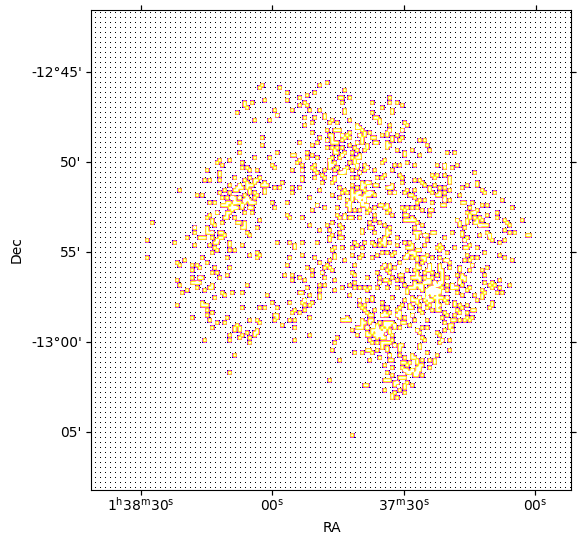

<Figure size 640x480 with 0 Axes>

In [130]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import pyregion

from matplotlib.patches import Annulus, Circle

kernel = Gaussian2DKernel(x_stddev=1)
# 'EPN_corr_counts'
file = f"{path}/images/sumsrc_err_xis0_img.fits"
hdu = fits.open(f'{file}')[0]
image_data = hdu.data
print(image_data.shape)
fig= plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
# image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
# astropy_conv = convolve(image_data, kernel)
print(np.nanmin(image_data[image_data>0]))
plt.imshow(image_data, cmap='gnuplot2', norm = colors.LogNorm(vmin = 1e-4,vmax=1), origin='lower')
plt.show()
plt.clf()


extract counts for every spectrum extraction region

In [16]:
# make masks for regions
from glob import glob
path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb/chandra_6e-15'

workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/spectras/cxb_robust_test/regions_0406_set1'
os.chdir(f'{workpath}/regions')
reglist = glob('*.reg')
newf = open(f'{workpath}/bin/make_masks.sh', 'w')
for reg in reglist:
    name = reg.split('.')[0]
    newf.write(f"ftimgcalc regions/{name}.fits 'regfilter(\"regions/{name}.reg\",A.P1,A.P2) ? (1):(0)' a={path}/images/sumsrc_xis0_img.fits clobber=yes\n")
newf.close()

In [24]:
# farith mask with sum image
os.chdir(f'{workpath}/regions')
reglist = glob('*.fits')
# reglist = ['werner_fila_1.6.fits', 'bkg_230309.fits']
newf = open(f'{workpath}/bin/ext_ps.sh', 'w')
for x in [0,1,3]:
    reg = 'rui_srcs_ht10e-15_suzaku_altered_ht18e-15_enlarge_alter'
    newf.write(f'farith regions/{reg}.fits {path}/images/sumsrc_xis{x}_img.fits annu_img/sumsrc_xis{x}_img_psexcluded.fits "*"\n')
    newf.write(f'farith regions/{reg}.fits {path}/images/sumsrc_err_xis{x}_img.fits annu_img/sumsrc_xis{x}_err_psexcluded.fits "*"\n')
newf.close()
newf = open(f'{workpath}/bin/ext_annu_img.sh', 'w')
for x in [0,1,3]:
    # for j in [2,3]:
    #     for i in [1,2,3]:
    #         reg = f'annu_a22{j}_{i}_xis{x}'
    #         newf.write(f'farith regions/{reg}.fits annu_img/sumsrc_xis{x}_img_psexcluded.fits annu_img/sumsrc_xis{x}_img_{reg}.fits "*"\n')
    #         newf.write(f'farith regions/{reg}.fits annu_img/sumsrc_xis{x}_err_psexcluded.fits annu_img/sumsrc_xis{x}_err_{reg}.fits "*"\n')
    newf.write(f'farith regions/filabox.fits annu_img/sumsrc_xis{x}_img_psexcluded.fits annu_img/sumsrc_xis{x}_img_filabox.fits "*"\n')
    newf.write(f'farith regions/bkg_230309.fits annu_img/sumsrc_xis{x}_img_psexcluded.fits annu_img/sumsrc_xis{x}_img_bkg_230309.fits "*"\n')
    newf.write(f'farith regions/filabox.fits annu_img/sumsrc_xis{x}_err_psexcluded.fits annu_img/sumsrc_xis{x}_err_filabox.fits "*"\n')
    newf.write(f'farith regions/bkg_230309.fits annu_img/sumsrc_xis{x}_err_psexcluded.fits annu_img/sumsrc_xis{x}_err_bkg_230309.fits "*"\n')
newf.close()
'''
ftimgcalc ../regions/werner_fila_1.6.fits 'regfilter("../regions/werner_fila_1.6.reg",A.P1,A.P2) ? (1):(0)' a=../images/sumsrc_xis0_img.fits clobber=yes
ftimgcalc ../regions/bkg_230309.fits 'regfilter("../regions/bkg_230309.reg",A.P1,A.P2) ? (1):(0)' a=../images/sumsrc_err_xis3_img.fits clobber=yes
'''

'\nftimgcalc ../regions/werner_fila_1.6.fits \'regfilter("../regions/werner_fila_1.6.reg",A.P1,A.P2) ? (1):(0)\' a=../images/sumsrc_xis0_img.fits clobber=yes\nftimgcalc ../regions/bkg_230309.fits \'regfilter("../regions/bkg_230309.reg",A.P1,A.P2) ? (1):(0)\' a=../images/sumsrc_err_xis3_img.fits clobber=yes\n'

In [21]:
# farith masked regions with ps regions
newf = open(f'{workpath}/bin/ext_annu_ps_img.sh', 'w')
for x in [0,1,3]:
    for j in [2,3]:
        for i in [1,2,3]:
            reg = f'annu_a22{j}_{i}_xis{x}'
            newf.write(f'farith regions/{reg}.fits regions/rui_srcs_ht10e-15_suzaku_altered_ht18e-15_enlarge_alter.fits regions/{reg}_psexcluded.fits "*"\n')
newf.write(f'farith regions/filabox.fits regions/rui_srcs_ht10e-15_suzaku_altered_ht18e-15_enlarge_alter.fits regions/filabox_psexcluded.fits "*"\n')
newf.write(f'farith regions/bkg_230309.fits regions/rui_srcs_ht10e-15_suzaku_altered_ht18e-15_enlarge_alter.fits regions/bkg_230309_psexcluded.fits "*"\n')
newf.close()


In [23]:
# get areas from above regions by counting pixels using fimgstat
import pandas as pd

areas = {'annu_a222_1_xis0':163, 'annu_a222_2_xis0':1225, 'annu_a222_3_xis0':1712, 
    'annu_a223_1_xis0':108, 'annu_a223_2_xis0':728, 'annu_a223_3_xis0':1234,
    'annu_a222_1_xis1':163, 'annu_a222_2_xis1':1225, 'annu_a222_3_xis1':1599,
    'annu_a223_1_xis1':108, 'annu_a223_2_xis1':735, 'annu_a223_3_xis1':1255,
    'annu_a222_1_xis3':163, 'annu_a222_2_xis3':1225, 'annu_a222_3_xis3':1466,
    'annu_a223_1_xis3':108, 'annu_a223_2_xis3':733, 'annu_a223_3_xis3':1248,
    'filabox':614, 'bkg':440}



get cts to log and sum log

In [15]:
for x in 0 1 3
do
rm sum_xis${x}.log
for j in 1 2 3
do
for i in 2 3
do
export root=sumsrc_xis${x}_annu_A22${i}_${j}_xis${x}
fimgstat ${root}.fits INDEF INDEF >> sum_xis${x}.log
done
done
fimgstat sumsrc_xis${x}_fila_box.fits INDEF INDEF >> sum_xis${x}.log
done



SyntaxError: expected ':' (1793332989.py, line 1)

In [5]:
import numpy as np
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/spectras/spectras_230317/annu_img'
xissim_cts = {}
for x in [0,1,3]:
    xissim_cts[f'xis{x}'] = np.zeros(7)
    f = open(f'{workpath}/sum_xis{x}.log')
    lines = f.readlines()
    i = 0
    for line in lines:
        if 'The sum of the selected image' in line:
            xissim_cts[f'xis{x}'][i] = float(line.split('=')[-1])
            i+=1
            

In [14]:
print(xissim_cts)

{'xis0': array([152.,  30., 304., 118., 152., 139.]), 'xis1': array([141.,  40., 302., 136., 132., 127.]), 'xis3': array([136.,  34., 313., 155., 163., 146.])}


calculate pointsources contribution for every regions

In [6]:
# regions = ['A222_1','A222_2','A222_3','A222_4a','A222_4b','A222_5a', 'A222_5b', 
#     'A223_1','A223_2','A223_3','A223_4b','A223_5a', 'A223_5b', 'werner', 'bkg']
# xissim_xi0_cts = np.array([43,112,176,9,62,11,18,7,11,23,37,62,49,23,27,40])
# xissim_xi1_cts = np.array([35,112,180,8,78,11,12,15,22,28,35,61,50,25,46,41])
# xissim_xi3_cts = np.array([32,120,172,6,74,13,9,8,16,25,43,70,54,30,38,32])
# exclude A223_4a
# mask[[-6]] = False
# xissim_xi0_cts = xissim_xi0_cts[mask]
# xissim_xi1_cts = xissim_xi1_cts[mask]
# xissim_xi3_cts = xissim_xi3_cts[mask]

regions = ['A222_1','A222_2','A222_3', 
    'A223_1','A223_2','A223_3', 'fila', 'bkg']

mask = np.ones(len(xissim_cts['xis0']), dtype=bool)

xissim_sum_xi0 = 1470
xissim_sum_xi1 = 1514
xissim_sum_xi3 = 1573
sum_flux = 9.8002e-13
sum_flux_err = 3.5e-13 # 3.5e-13, 2.7e-13
f_xi0 = xissim_cts['xis0']/xissim_sum_xi0*sum_flux
f_xi1 = xissim_cts['xis1']/xissim_sum_xi1*sum_flux
f_xi3 = xissim_cts['xis3']/xissim_sum_xi3*sum_flux
ferr_xi0 = xissim_cts['xis0']/xissim_sum_xi0*sum_flux_err
ferr_xi1 = xissim_cts['xis1']/xissim_sum_xi1*sum_flux_err
ferr_xi3 = xissim_cts['xis3']/xissim_sum_xi3*sum_flux_err
newf = open(f'{workpath}/ps_flux.csv', 'w')
newf.write('region, flux_xi0, flux_xi0_err, ratio, flux_xi1, flux_xi1_err, ratio, flux_xi3, flux_xi3_err, ratio\n')
for i in range(len(regions)):
    newf.write(f"{regions[i]}, {f_xi0[i]}, {ferr_xi0[i]}, {f'{ferr_xi0[i]/f_xi0[i]*100}%'}, {f_xi1[i]}, {ferr_xi1[i]}, {f'{ferr_xi1[i]/f_xi1[i]*100}%'}, {f_xi3[i]}, {ferr_xi3[i]},{f'{ferr_xi3[i]/f_xi3[i]*100}%'}\n")
newf.close()

IndexError: index 7 is out of bounds for axis 0 with size 7

In [13]:
# for bkg region in suzaku
def suzaku_norm(flux, area):
    return flux/area*400*3.14/5.166e-9
print(suzaku_norm(2.7e-14, 2**2*3.14), suzaku_norm(3.5e-13*40/1470, 2**2*3.14))
print(suzaku_norm(1.487e-14, 2**2*3.14))
print(suzaku_norm(6.412e-14, 2**2*3.14), suzaku_norm(13.1e-15, 2**2*3.14))

0.0005226480836236933 0.00018435558505244917
0.00028784359272164155
0.0012411924119241193 0.0002535811072396439


In [168]:
areas = {'A222_1':1*3.14,'A222_2':(2.5**2-1)*3.14,'A222_3':(3.5**2-2.5**2)*3.14,'A222_4a':(5**2-3.5**2)*3.14,
'A222_4b':(5**2-3.5**2)*3.14*65/360,'A222_5a':(7**2-5**2)*3.14*30/360, 'A222_5b':(7**2-5**2)*3.14*30/360, 
'A223_1':1*3.14,'A223_2':(2**2-1)*3.14*300/360,'A223_3':(3**2-2**2)*3.14*300/360,
'A223_4b':(5.5**2-3**2)*3.14*85/360,'A223_5a':(8**2-5.5**2)*3.14*47/360, 'A223_5b':(8**2-5.5**2)*3.14*20/360,'werner': 1.6**2*3.14, 'bkg': 2**2*3.14 }
def suzaku_norm(flux, area):
    return flux/area*400*3.14/5.166e-9

n_xi0 = []
n_err_xi0 = []
for i in range(len(flux)):
    n_xi0.append(suzaku_norm(flux[i], areas[regions[i]]))
    n_err_xi0.append(suzaku_norm(ferr[i], areas[regions[i]]))

write the results to table

In [169]:
print(regions)
print(n_xi0)
print(n_err_xi0)

['A222_1', 'A222_2', 'A222_3', 'A222_4a', 'A222_4b', 'A222_5a', 'A222_5b', 'A223_1', 'A223_2', 'A223_3', 'A223_4b', 'A223_5a', 'A223_5b', 'werner', 'bkg']
[0.0022196865428323873, 0.0011012398352036649, 0.0015142047734050391, 3.64380827824742e-05, 0.001390253004623631, 0.0002839133950134448, 0.0004645855554765461, 0.0003613443209262026, 0.0002271307160107559, 0.0002849458073589483, 0.0006378807903567247, 0.0005740505523933997, 0.0006332129052421073, 0.0005444361978240775, 0.0005162061727517178]
[0.0013068704059246614, 0.0006483698137920804, 0.0008915084939641102, 2.1453412956355597e-05, 0.0008185302174117213, 0.0001671578426182707, 0.00027353101519353386, 0.00021274634515052636, 0.00013372627409461655, 0.00016776568931870078, 0.000375560923283025, 0.0003379800093171482, 0.00037281264293044617, 0.0003205441584299225, 0.00030392335021503763]


sum up cosmic variance and pointsrc flux

In [37]:
import pandas as pd
import numpy as np
path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb'
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/spectras/spectras_230317'

regions = ['A222_1','A222_2','A222_3', 
    'A223_1','A223_2','A223_3', 'fila', 'bkg']
def suzaku_norm(flux, area):
    return flux/area*400*3.14/5.2431e-9
cv_data = np.array(pd.read_csv(f'{workpath}/cxb_cosmicvariance.csv'))
ps_data = np.array(pd.read_csv(f'{workpath}/ps_flux.csv'))
sumflux = cv_data[:,2] + ps_data[:,1]
sumerr = (cv_data[:,3]**2 + ps_data[:,2]**2)**0.5

f = open(f'{workpath}/total_cxb_xissim_xi0.csv', 'w')
f.write('region,area,cxbflux,cxbflux_err,ratio,pointsrcflux,pointsrcflux_err,sumflux,sumflux_err,sumerr_ratio,suzaku_norm,suzaku_norm_err,suzaku_norm_hi,suzaku_norm_lo\n')
for i in range(len(regions)):
    sum_norm = suzaku_norm(sumflux[i], cv_data[:,1][i])
    sum_norm_err = suzaku_norm(sumerr[i], cv_data[:,1][i])
    f.write(f'{cv_data[:,0][i]}, {cv_data[:,1][i]:.2f}, {cv_data[:,2][i]*1e15:.2f}, {cv_data[:,3][i]*1e15:.2f}, {cv_data[:,4][i]}, {ps_data[:,1][i]*1e15:.2f}, {ps_data[:,2][i]*1e15:.2f}, {sumflux[i]*1e15:.2f}, {sumerr[i]*1e15:.2f}, {sumerr[i]/sumflux[i]*100:.2f}%, {sum_norm*1e4:.2f}, {sum_norm_err*1e4:.2f}, {(sum_norm + sum_norm_err)*1e4:.2f}, {(sum_norm - sum_norm_err)*1e4:.2f}\n')
f.write('NOTE: flux *1e-15, norm*1e-4')
f.close()

In [ ]:
vary pointsrc norm

In [35]:
import pandas as pd
import numpy as np
path = '/Users/eusracenorth/Documents/suzaku_A222-223/xissim_cxb'
regions = ['A222_1','A222_2','A222_3','A222_4a','A222_4b','A222_5a', 'A222_5b', 
    'A223_1','A223_2','A223_3','A223_4b','A223_5a', 'A223_5b', 'werner', 'bkg']
def suzaku_norm(flux, area):
    return flux/area*400*3.14/5.2431e-9
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/spectras/spectras_230307'
cv_data = np.array(pd.read_csv(f'{workpath}/cxb_cosmicvariance.csv'))
ps_data = np.array(pd.read_csv(f'{workpath}/ps_flux.csv'))
sumflux = cv_data[:,2] + ps_data[:,1]
sumerr = (cv_data[:,3]**2 + ps_data[:,2]**2)**0.5

f = open(f'{workpath}/total_cxb_xissim_xi0.csv', 'w')
f.write('region,area,cvflux,cvflux_err,ratio,psflux,psflux_err,cvportion,psportion,sumflux,sumflux_err,sumerr_ratio,suzaku_norm,suzaku_norm_err,suzaku_norm_hi,suzaku_norm_lo\n')
for i in range(len(regions)):
    sum_norm = suzaku_norm(sumflux[i], cv_data[:,1][i])
    sum_norm_err = suzaku_norm(sumerr[i], cv_data[:,1][i])
    f.write(f'{cv_data[:,0][i]}, {cv_data[:,1][i]:.2f}, {cv_data[:,2][i]*1e15:.2f}, {cv_data[:,3][i]*1e15:.2f}, {cv_data[:,4][i]}, {ps_data[:,1][i]*1e15:.2f}, {ps_data[:,2][i]*1e15:.2f}, {cv_data[:,2][i]/sumflux[i]*100:.2f}%, {ps_data[:,1][i]/sumflux[i]*100:.2f}%, {sumflux[i]*1e15:.2f}, {sumerr[i]*1e15:.2f},{sum_norm_err/sum_norm*100:.2f}%, {sum_norm*1e4:.2f}, {sum_norm_err*1e4:.2f}, {(sum_norm + sum_norm_err)*1e4:.2f}, {(sum_norm - sum_norm_err)*1e4:.2f}\n')
f.write('NOTE: flux *1e-15, norm*1e-4')
f.close()